<a href="https://colab.research.google.com/github/nikibhatt/DS-Unit-2-Applied-Modeling/blob/master/LS_DS9_231.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Burritos example

In [0]:
import pandas as pd
url = ('https://raw.githubusercontent.com/'
'LambdaSchool/DS-Unit-2-Linear-Models'
'/master/data/burritos/burritos.csv')
df = pd.read_csv(url)
df['overall'].describe()

count    421.000000
mean       3.620887
std        0.755718
min        1.000000
25%        3.100000
50%        3.800000
75%        4.100000
max        5.000000
Name: overall, dtype: float64

# Choose your target. 

Which column in your tabular dataset will you predict?

In [0]:
# Derive binary classification target:
# We define a 'Great' burrito as having an
# overall rating of 4 or higher, on a 5 point scale.
# Drop unrated burritos.
df = df.dropna(subset=['overall'])
df['Great'] = df['overall'] >= 4
df['Great'].describe()

count       421
unique        2
top       False
freq        239
Name: Great, dtype: object

I've derived my own target to redefine the target (previously 1-5 stars) to a binary classification problem: Predict if a burrito is "Great" or not.

# How is your target distributed?

Classification: How many classes? Are the classes imbalanced?

In [0]:
y = df['Great']

In [0]:
y.nunique()

2

In [0]:
y.value_counts(normalize=True).max()

0.5676959619952494

In [0]:
y.value_counts(normalize=True)

False    0.567696
True     0.432304
Name: Great, dtype: float64

There are 2 classes, this is a binary classification problem. The majority class occurs with 57% frequency, so this is not too imbalanced. I could just use accuracy score as my evaluation metric.

Precision when predicting great burritos may be the most important because I'm only going to eat one, so I want to make sure it's good.

(On the other hand, is a "bad" burrito really that bad? Not to me, not from a taste perspective.)

Recall when predicting great burritos could mean trying more things to make sure you don't miss some new, different, great burrito that you otherwise wouldn't have tried.

Which burito place would you take your first date to? Precision.

# Begin to clean and explore your data

In [0]:
df['Burrito'].value_counts()

California             101
Carne asada             29
California              26
Carnitas                23
Surf & Turf             14
                      ... 
California Chipotle      1
Chicken avocado          1
Deborah's special        1
Surf and turf            1
Surf and turf            1
Name: Burrito, Length: 132, dtype: int64

In [0]:
df['Burrito'].unique()

array(['California ', 'Carnitas', 'Carne asada', 'California',
       'combo chicken', 'Monster California', 'Carne Asada',
       'Surf & Turf', 'Chile verde pork', 'battered fish ',
       'Surf and turf ', 'Adobada ', 'Barbacoa', '2 in 1', 'Adobado',
       'Shredded beef', 'Hawaiian', 'Bandido', 'Campeon', 'carne asada',
       'California chicken', 'Azteca', 'Lobster', 'Al pastor', 'Custom',
       'Machaca', 'Quesaburro', 'Philly ', 'Quesa', 'Surf and turf',
       'Mahi', 'Addiction', 'Oaxacalifornia', "Deborah's special",
       'Chicken nopalito', 'Adobada', 'Chicken', 'California Everything',
       'Chile relleno and carnitas', 'California (only cheese)', 'Fish',
       'Chimichanga beef', 'Pastor', 'El Hawaiiano ', 'Shrimp',
       'El Rusio', 'Bacon breakfast', 'Chile Relleno', 'Bomb', 'Arizona',
       'California Burrito', '619 Burrito Original', 'Chicken asada',
       'Carne adobada ', 'Bean and cheese', 'Pokirrito classic ',
       'Mauna Lani', 'Especial ', 'Ranchero

In [0]:
# Clean/combine the Burrito categories
df['Burrito'] = df['Burrito'].str.lower()

In [0]:
df['Burrito'].nunique()

123

In [0]:
california = df['Burrito'].str.contains('california')
asada = df['Burrito'].str.contains('asada')
surf = df['Burrito'].str.contains('surf')
carnitas = df['Burrito'].str.contains('carnitas')

In [0]:
california.value_counts()

False    241
True     180
Name: Burrito, dtype: int64

In [0]:
df.loc[california, 'Burrito'] = 'California'
df.loc[asada, 'Burrito'] = 'Asada'
df.loc[surf, 'Burrito'] = 'Surf & Turf'
df.loc[carnitas, 'Burrito'] = 'Carnitas'
df.loc[~california & ~asada & ~surf & ~carnitas, 'Burrito'] = 'Other'

In [0]:
df['Burrito'].value_counts()

California     169
Other          156
Asada           43
Surf & Turf     28
Carnitas        25
Name: Burrito, dtype: int64

In [0]:
# Drop some high cardinality categoricals
df = df.drop(columns=['Notes', 'Location', 'Reviewer', 'Address', 'URL', 'Neighborhood'])

# What happens if we *DON'T* drop features with leakage?

In [0]:
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier

target = 'Great'
features = df.columns.drop(target)
X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=42
)

pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(), 
    DecisionTreeClassifier(max_depth=3)
)

cross_val_score(pipeline, X_train, y_train, scoring='accuracy', cv=5)

array([1., 1., 1., 1., 1.])

In [0]:
pipeline.fit(X_train, y_train)
tree = pipeline.named_steps['decisiontreeclassifier']
encoder = pipeline.named_steps['ordinalencoder']
X_train_encoded = encoder.transform(X_train)

importances = pd.Series(tree.feature_importances_, X_train_encoded.columns)
importances.sort_values().plot.barh();

ValueError: ignored

# Titanic

In [0]:
df = sns.load_dataset('titanic')

target = 'survived'
features = df.columns.drop(target)
X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=42)

pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(), 
    DecisionTreeClassifier(max_depth=3)
)

cross_val_score(pipeline, X_train, y_train, scoring='accuracy', cv=5)

array([1., 1., 1., 1., 1.])

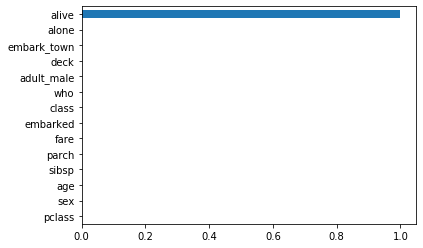

In [0]:
pipeline.fit(X_train, y_train)
tree = pipeline.named_steps['decisiontreeclassifier']

importances = pd.Series(tree.feature_importances_, X_train.columns)
importances.sort_values().plot.barh();

In [0]:
df.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


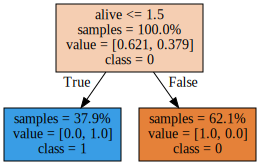

In [0]:
import graphviz
from sklearn.tree import export_graphviz

pipeline.fit(X_train, y_train)
tree = pipeline.named_steps['decisiontreeclassifier']

dot_data = export_graphviz(
    tree, 
    out_file=None, 
    feature_names=X.columns, 
    class_names=y.unique().astype(str), 
    filled=True, 
    impurity=False, 
    proportion=True)

graphviz.Source(dot_data)

# Regression: NYC apartment data

In [0]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/'
    !pip install category_encoders==2.*
    
# If you're working locally:
else:
    DATA_PATH = '../data/'

In [0]:
import numpy as np
import pandas as pd

# Read New York City apartment rental listing data
df = pd.read_csv(DATA_PATH+'apartments/renthop-nyc.csv')
assert df.shape == (49352, 34)

In [0]:
y = df['price']

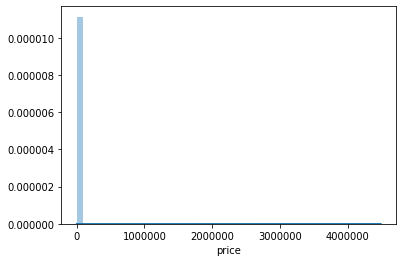

In [0]:
%matplotlib inline
import seaborn as sns
sns.distplot(y);

In [0]:
y.describe()

count    4.935200e+04
mean     3.830174e+03
std      2.206687e+04
min      4.300000e+01
25%      2.500000e+03
50%      3.150000e+03
75%      4.100000e+03
max      4.490000e+06
Name: price, dtype: float64

In [0]:
(y < 100).value_counts()

False    49350
True         2
Name: price, dtype: int64

# Are some observations outliers? 

Will you exclude
them?

In [0]:
# Yes! There are outliers
# Some prices that are so high or low it doesn't really make sense.
# SOme locations that aren't even in New York City.

In [0]:
# Remove the most extreme 1% prices,
# the most extreme .1% latitudes, &
# the most extreme .1% longitudes
df = df[(df['price'] >= np.percentile(df['price'], 0.5)) & 
        (df['price'] <= np.percentile(df['price'], 99.5)) & 
        (df['latitude'] >= np.percentile(df['latitude'], 0.05)) & 
        (df['latitude'] < np.percentile(df['latitude'], 99.95)) &
        (df['longitude'] >= np.percentile(df['longitude'], 0.05)) & 
        (df['longitude'] <= np.percentile(df['longitude'], 99.95))]

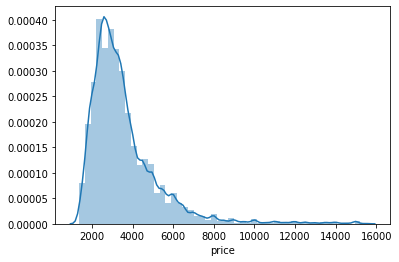

In [0]:
y = df['price']
sns.distplot(y);

In [0]:
y.describe()

count    48817.000000
mean      3579.585247
std       1762.430772
min       1375.000000
25%       2500.000000
50%       3150.000000
75%       4095.000000
max      15500.000000
Name: price, dtype: float64

In [0]:
import numpy as np
y_log = np.log1p(y)

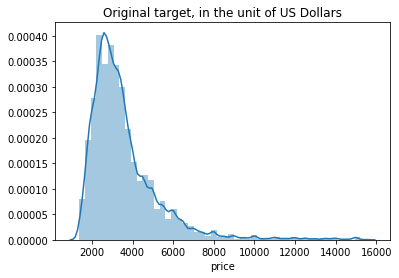

In [0]:
import matplotlib.pyplot as plt
sns.distplot(y)
plt.title('Original target, in the unit of US Dollars');

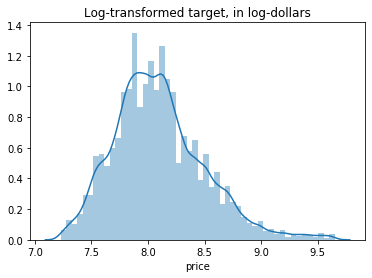

In [0]:
sns.distplot(y_log)
plt.title('Log-transformed target, in log-dollars');

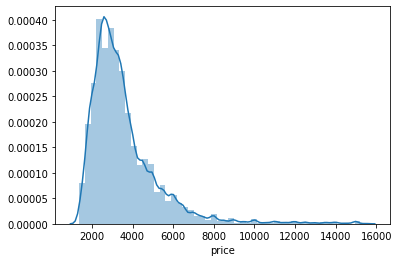

In [0]:
y_untransformed = np.expm1(y_log)
sns.distplot(y_untransformed);

In [0]:
y_train_log = np.log1p(y_train)
y_val_log = np.log1p(y_val)
model.fit(X_train, y_train_log)
y_pred_log = model.predict(X_val)
y_pred = np.expm1(y_pred_log)
mean_absolute_error(y_val, y_pred)